In [3]:
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
import plotly.offline as pyo
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from sklearn.decomposition import PCA

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor


In [4]:
df= pd.read_excel('Dataset.xlsx')

# Save data as a CSV file
df.to_csv('train.csv', index=False)

# Remove columns with all zeros
data = df.loc[:, (df != 0).any(axis=0)]

missing_percentage = data.isnull().sum() / len(data)

# Identify columns with more than 60% missing values
columns_to_drop = missing_percentage[missing_percentage > 0.6].index.tolist()

data.drop(columns_to_drop, axis=1, inplace=True)



In [ ]:

# Iterative filling of missing values ​​in random forest regression model
missing_value_columns = data.columns[data.isnull().any()].tolist()

imputer = IterativeImputer(RandomForestRegressor(), max_iter=20, random_state=42)
data[missing_value_columns] = imputer.fit_transform(data[missing_value_columns])

In [ ]:

data['EDC_delta13C'] = data['EDC_delta13C'].replace('ND', np.nan)
data['PCE_delta13C'] = data['PCE_delta13C'].replace('ND', np.nan)

data.dropna(subset=['EDC_delta13C'], inplace=True)


In [ ]:
# Create an instance of the Random Forest Regressor
rf = RandomForestRegressor(
    n_estimators=35,      # Number of trees
    max_depth=4,           # Maximum depth of the trees
    min_samples_split=8,  # Minimum number of samples required to split an internal node
    min_samples_leaf=4,    # Minimum number of samples required at a leaf node
    max_features='sqrt',   # Number of features to consider when looking for the best split, set to the square root of the total number of features
    bootstrap=True,        # Use bootstrap sampling
    oob_score=True,        # Use out-of-bag samples to estimate the R² score
    random_state=42,       # Control the randomness of the model
)

# Features: All columns in the dataset except for the column named 'EDC_delta13C'
X = data.drop(['EDC_delta13C','PCE_delta13C','Depth','ID'], axis=1)

# Target: The column named 'EDC_delta13C' in the dataset
y = data['EDC_delta13C']

# Split the data into training and testing sets with an 80/20 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model using the training data
rf.fit(X_train, y_train)

feature_importances = rf.feature_importances_
feature_names = X.columns
print(len(feature_names))
print(len(feature_importances))

feature_scores = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Print the features sorted by importance
print(feature_scores.sort_values(by='Importance', ascending=False))



In [9]:
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score

# Sort by importance and select the top 30 features
top_30_features = feature_scores.sort_values(by='Importance', ascending=False).head(30)

# Extract the names of the top 30 most important features
top_30_feature_names = top_30_features['Feature'].values

# Create a new training dataset using these features
X_train_top30 = X[top_30_feature_names]

# Split the data into training and testing sets
X_trains, X_tests, y_train, y_test = train_test_split(X_train_top30, y, test_size=0.2, random_state=42)

# The model can be retrained with this new feature set or used for other analyses
rf.fit(X_trains, y_train)

# Predict on the training set
y_train_pred = rf.predict(X_trains)

# Predict on the test set
y_pred = rf.predict(X_tests)

y_test_pred = rf.predict(X_tests)

# Calculate MSE, RMSE, and R² for the training set
train_mse = mean_squared_error(y_train, y_train_pred)
train_rmse = np.sqrt(train_mse)
train_r2 = r2_score(y_train, y_train_pred)

# Calculate MSE, RMSE, and R² for the test set
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test, y_test_pred)

# Output the results
print("Training set model performance:")
print(f"Train MSE: {train_mse}")
print(f"Train RMSE: {train_rmse}")
print(f"Train R² score: {train_r2}")
print("-----------------------------------")
print("Test set model performance:")
print(f"Test MSE: {test_mse}")
print(f"Test RMSE: {test_rmse}")
print(f"Test R² score: {test_r2}")


Training set model performance:
Train MSE: 18.395921467396576
Train RMSE: 4.289046685150043
Train R² score: 0.5815944825406671
-----------------------------------
Test set model performance:
Test MSE: 23.04005436586821
Test RMSE: 4.800005663107932
Test R² score: 0.3899069104531796


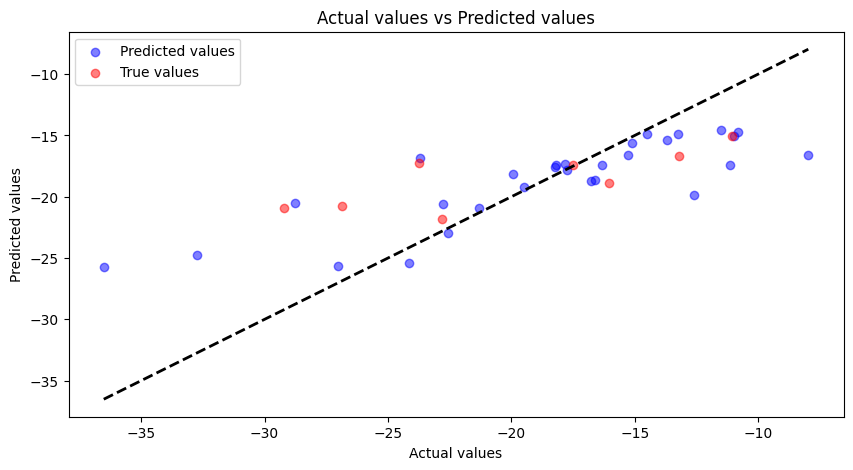

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Create a figure and axis
plt.figure(figsize=(10, 5))

# Plot scatter plot for training data
plt.scatter(y_train, y_train_pred, color='blue', alpha=0.5, label='Predicted values (Training)')
# Plot scatter plot for testing data
plt.scatter(y_test, y_test_pred, color='red', alpha=0.5, label='Predicted values (Testing)')

# Calculate the minimum and maximum values for plotting the diagonal line
min_val = min(min(y_train), min(y_test), min(y_train_pred), min(y_test_pred))
max_val = max(max(y_train), max(y_test), max(y_train_pred), max(y_test_pred))

# Plot the diagonal line
plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)

# Set the title and labels for the axes
plt.title('Actual values vs Predicted values')
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.legend()

# Show the plot
plt.show()



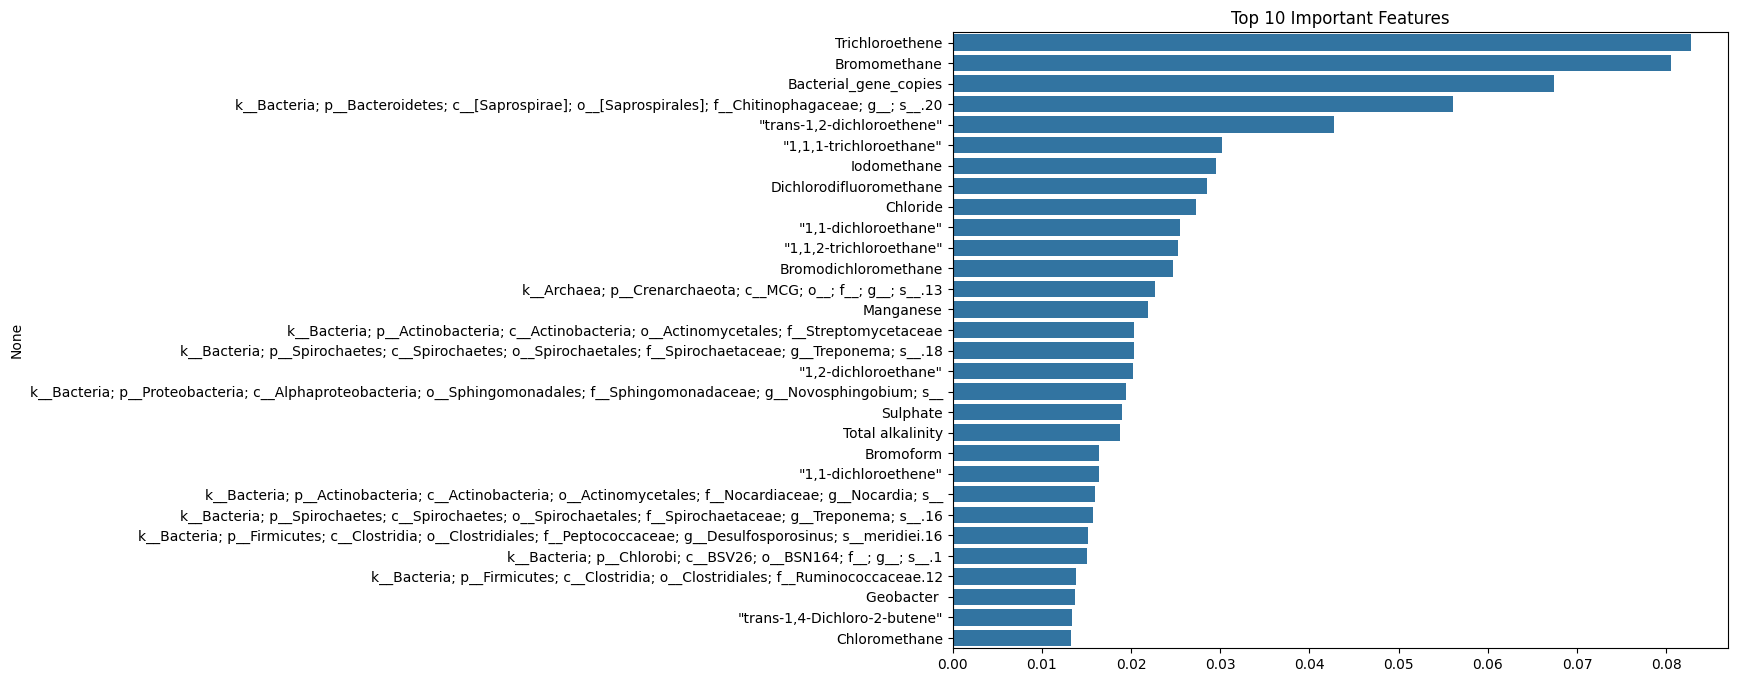

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Sort feature importances and select the top 30 most important features for visualization
sorted_idx = np.argsort(feature_importances)[::-1]
top_idx = sorted_idx[:30]

plt.figure(figsize=(10, 8))
sns.barplot(x=feature_importances[top_idx], y=feature_names[top_idx])
plt.title('Top 30 Important Features')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

